In [41]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
import dynesty
import joblib
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from matplotlib.colors import LogNorm

In [42]:
duration = 4
sampling_frequency = 2048
t0_gps = 1126259460.4
n_samples = duration*sampling_frequency
time = np.linspace(0, duration, n_samples)

delta = 5
ras = np.radians(np.arange(0, 360, delta))
decs = np.radians(np.arange(-90, 90, delta))
ra_s = np.radians(np.linspace(-180, 180, len(ras)+1))
dec_s = np.radians(np.linspace(-90, 90, len(decs)+1))
radec_s = np.array([(ra, dec) for ra in ra_s for dec in dec_s])
radec = np.array([(ra, dec) for ra in ras for dec in decs])
radec_map = radec.reshape(36, 72, 2)

In [43]:
waveform = joblib.load('data/waveform.pkl')
h1_strain = joblib.load('data/H1_strain.pkl')
l1_strain = joblib.load('data/L1_strain.pkl')
v1_strain = joblib.load('data/V1_strain.pkl')
h1_psd = joblib.load('data/H1_psd.pkl')
l1_psd = joblib.load('data/L1_psd.pkl')
v1_psd = joblib.load('data/V1_psd.pkl')

In [44]:
IFOH = bilby.gw.detector.InterferometerList(['H1'])[0]
IFOH.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=h1_psd['Hz'].values, psd_array=h1_psd['PSD'].values)
# IFOH.frequency_array = h1_psd['Hz']

IFOL = bilby.gw.detector.InterferometerList(['L1'])[0]
IFOL.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=l1_psd['Hz'].values, psd_array=l1_psd['PSD'].values)
# IFOL.frequency_array = l1_psd['Hz']

IFOV = bilby.gw.detector.InterferometerList(['V1'])[0]
IFOV.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=v1_psd['Hz'].values, psd_array=v1_psd['PSD'].values)
# IFOV.frequency_array = v1_psd['Hz']

In [45]:
def priors(u):
    tc_geo = u[0] * (t0_gps + 4 - (t0_gps)) + (t0_gps)
    DL = u[1] * (1000 - 1) + 1 #Gpc
    ra = u[2] * (2 * np.pi - 0) + 0
    dec = u[3] * (np.pi/2 - (-np.pi/2)) + (-np.pi/2)
    psi = u[4] * (np.pi - 0) + 0
    return np.array([tc_geo, DL, ra, dec, psi])

def log_likelihood(params):
    tc_geo = params[0]
    DL = params[1]
    ra = params[2]
    dec = params[3]
    psi = params[4]
    logl = 0

    for strain, IFO in zip(data_dfs, IFOS):
        fplus = IFO.antenna_response(ra, dec, tc_geo, psi, 'plus')
        fcross = IFO.antenna_response(ra, dec, tc_geo, psi, 'cross')
        template = waveform['h+'].values * fplus + waveform['hx'].values * fcross
        delay = IFO.time_delay_from_geocenter(ra, dec, tc_geo)
        phase_shift = np.exp(-1j * 2*np.pi * waveform['Hz'].values * delay)
        h = template * phase_shift
        h /= DL
        res = strain['h'] - h
        logl -= 2/duration*np.sum(np.vdot(res, res) / IFO.power_spectral_density.psd_array)

    return logl.real

In [ ]:
data_dfs = [h1_strain, l1_strain, v1_strain]
IFOS = [IFOH, IFOL, IFOV]
sampler = dynesty.NestedSampler(log_likelihood, priors, 5, nlive = 2000, sample = 'rwalk')
sampler.run_nested(dlogz=0.01, print_progress=True)
res = sampler.results
joblib.dump(res, 'data/dynesty_HLV.pkl')
joblib.dump(sampler, 'data/dynesty_HLV_sampler.pkl')

80346it [29:54, 44.77it/s, +2000 | bound: 245 | nc: 1 | ncall: 1904324 | eff(%):  4.329 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  1.171 | dlogz:  0.000 >  0.010]


['data/dynesty_HLV.pkl']

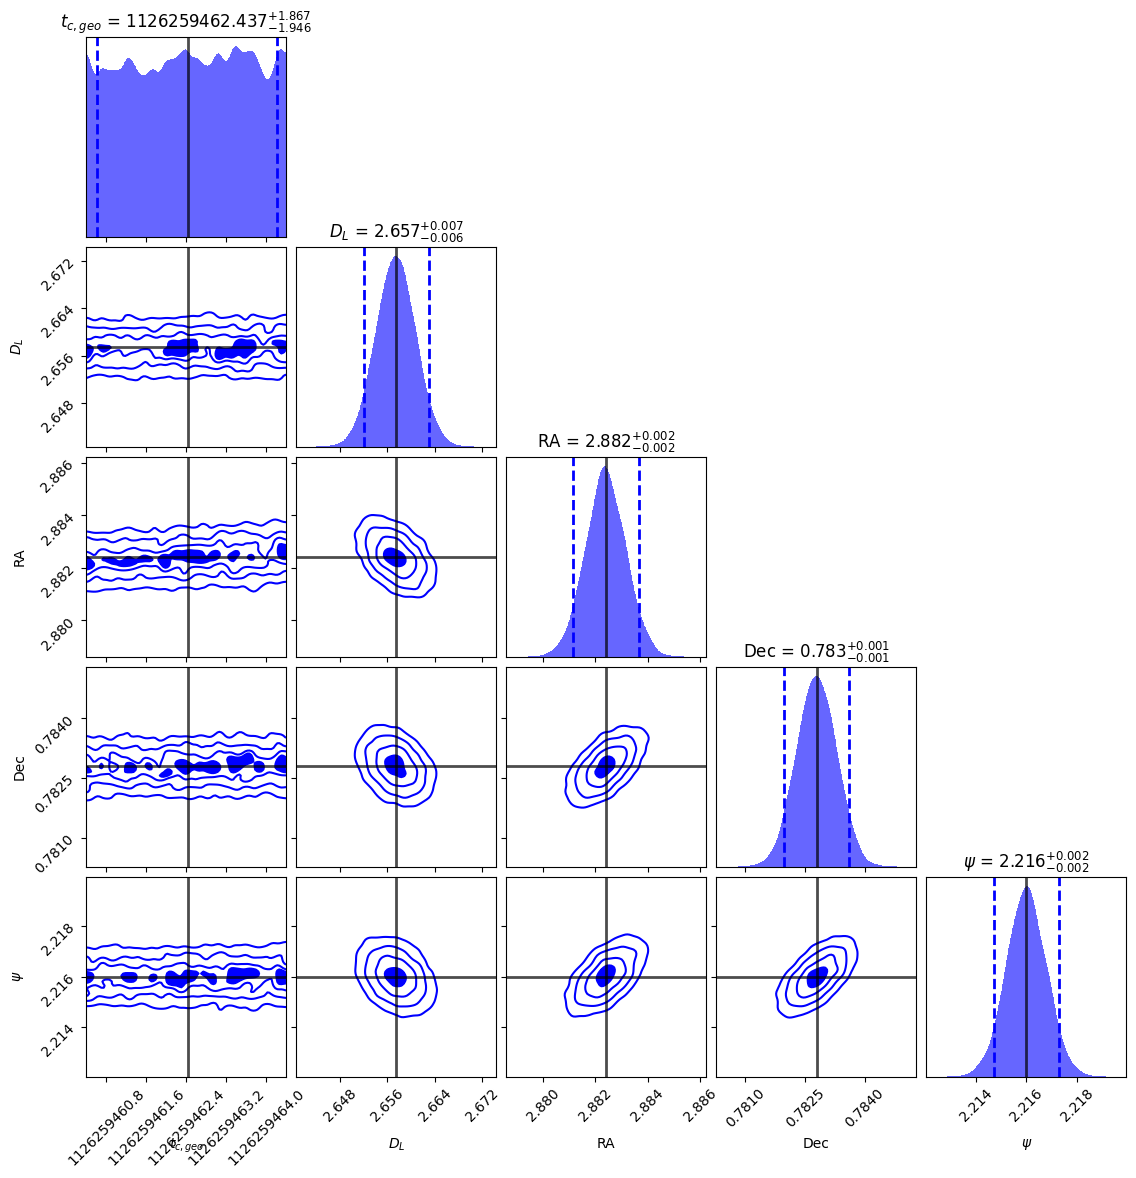

In [71]:
res = joblib.load('data/dynesty_HLV.pkl')
samples, weights = res.samples, res.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
fg, ax = dyplot.cornerplot(res, color='blue', truths=mean,
                           truth_color='black', show_titles=True,
                           quantiles=[0.05, 0.95], title_fmt='.3f', labels=[r'$t_{c, geo}$', r'$D_L$', 'RA', 'Dec', r'$\psi$'])
plt.savefig('figures/corner_HLV.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_34026/2739077299.py:22: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(RA, DEC, H.T, levels=3, cmap='Wistia', norm=LogNorm(vmin=1, vmax=np.max(H)), extend='both')


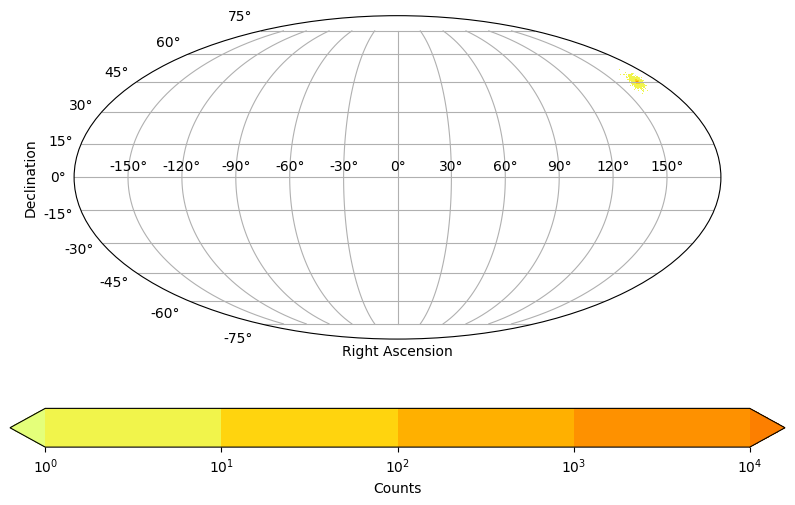

165.1495657887318 44.850516902372505


<Figure size 640x480 with 0 Axes>

In [76]:
samples = pd.DataFrame(dyfunc.resample_run(res).samples, columns=['tc_geo', 'DL', 'ra', 'dec', 'psi'])[30000:]

ra_rad = samples['ra'].values
ra_rad = np.where(ra_rad > np.pi, ra_rad - 2*np.pi, ra_rad)
dec_rad = samples['dec'].values

delta = 1
ras = np.radians(np.arange(0, 360, delta))
decs = np.radians(np.arange(-90, 90, delta))

ra_s = np.radians(np.linspace(-180, 180, len(ras)+1))
dec_s = np.radians(np.linspace(-90, 90, len(decs)+1))
H, ra_edges, dec_edges = np.histogram2d(ra_rad, dec_rad, bins=[len(ra_s), len(dec_s)])

ra_centers = (ra_edges[:-1] + ra_edges[1:]) / 2
dec_centers = (dec_edges[:-1] + dec_edges[1:]) / 2
RA, DEC = np.meshgrid(ra_centers, dec_centers)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='mollweide')

contour = ax.contourf(RA, DEC, H.T, levels=3, cmap='Wistia', norm=LogNorm(vmin=1, vmax=np.max(H)), extend='both')

ax.grid(True)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(contour, ax=ax, orientation='horizontal', label='Counts')
plt.show()
plt.savefig('figures/dynesty_map_HLV.png', dpi=300, bbox_inches='tight')
print(np.rad2deg(mean[2]), np.rad2deg(mean[3]))

In [ ]:
data_dfs = [h1_strain, l1_strain]
IFOS = [IFOH, IFOL]
sampler = dynesty.NestedSampler(log_likelihood, priors, 5, nlive = 2000, sample = 'rwalk')
sampler.run_nested(dlogz=0.01, print_progress=True)
res = sampler.results
joblib.dump(res, 'data/dynesty_HL.pkl')
joblib.dump(sampler, 'data/dynesty_HL_sampler.pkl')

76749it [20:53, 61.22it/s, +2000 | bound: 233 | nc: 1 | ncall: 1812645 | eff(%):  4.349 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  0.000 >  0.010]


['data/dynesty_HL.pkl']

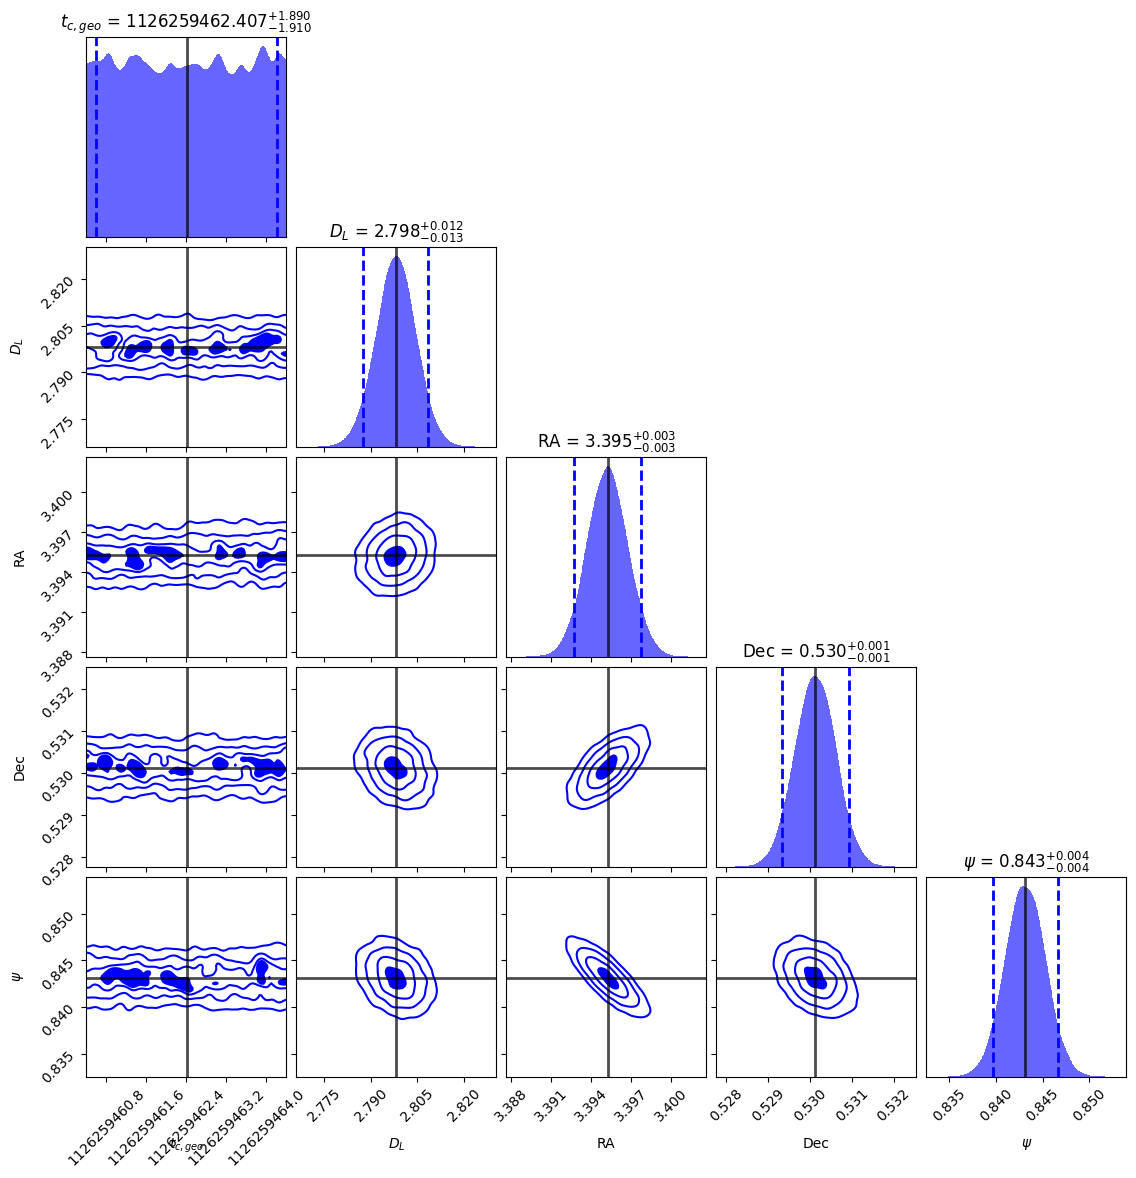

In [77]:
res = joblib.load('data/dynesty_HL.pkl')
samples, weights = res.samples, res.importance_weights()
mean, cov = dyfunc.mean_and_cov(samples, weights)
fg, ax = dyplot.cornerplot(res, color='blue', truths=mean,
                           truth_color='black', show_titles=True,
                           quantiles=[0.05, 0.95], title_fmt='.3f', labels=[r'$t_{c, geo}$', r'$D_L$', 'RA', 'Dec', r'$\psi$'])
plt.savefig('figures/corner_HL.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_34026/3887685569.py:22: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(RA, DEC, H.T, levels=3, cmap='Wistia', norm=LogNorm(vmin=1, vmax=np.max(H)), extend='both')


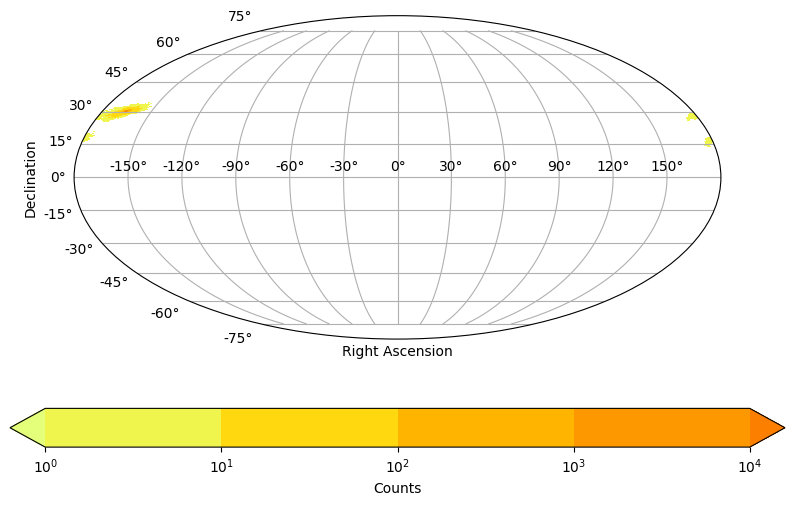

194.5322051515892 30.374250376746037


<Figure size 640x480 with 0 Axes>

In [78]:
samples = pd.DataFrame(dyfunc.resample_run(res).samples, columns=['tc_geo', 'DL', 'ra', 'dec', 'psi'])[30000:]

ra_rad = samples['ra'].values
ra_rad = np.where(ra_rad > np.pi, ra_rad - 2*np.pi, ra_rad)
dec_rad = samples['dec'].values

delta = 1
ras = np.radians(np.arange(0, 360, delta))
decs = np.radians(np.arange(-90, 90, delta))

ra_s = np.radians(np.linspace(-180, 180, len(ras)+1))
dec_s = np.radians(np.linspace(-90, 90, len(decs)+1))
H, ra_edges, dec_edges = np.histogram2d(ra_rad, dec_rad, bins=[len(ra_s), len(dec_s)])

ra_centers = (ra_edges[:-1] + ra_edges[1:]) / 2
dec_centers = (dec_edges[:-1] + dec_edges[1:]) / 2
RA, DEC = np.meshgrid(ra_centers, dec_centers)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='mollweide')

contour = ax.contourf(RA, DEC, H.T, levels=3, cmap='Wistia', norm=LogNorm(vmin=1, vmax=np.max(H)), extend='both')

ax.grid(True)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(contour, ax=ax, orientation='horizontal', label='Counts')
plt.show()
plt.savefig('figures/dynesty_map_HL.png', dpi=300, bbox_inches='tight')
print(np.rad2deg(mean[2]), np.rad2deg(mean[3]))